<a href="https://colab.research.google.com/github/TabethHamandawana/Code/blob/main/MSFT_Prediction_using_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

In [5]:
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [6]:
#Load the data
df = pd.read_csv('MSFT.csv')

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2021,222.529999,223.000000,214.809998,217.690002,211.605316,37130100
1,1/5/2021,217.259995,218.520004,215.699997,217.899994,211.809418,23823000
2,1/6/2021,212.169998,216.490005,211.940002,212.250000,206.317368,35930700
3,1/7/2021,214.039993,219.339996,213.710007,218.289993,212.188538,27694500
4,1/8/2021,218.679993,220.580002,217.029999,219.619995,213.481354,22956200


In [8]:
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])

Total number of days:  753
Total number of fields:  7


In [9]:
#Checking for null & NA values
print("Null values:", df.isnull().values.sum())
print("NA values:", df.isna().values.any())

Null values: 0
NA values: False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       753 non-null    object 
 1   Open       753 non-null    float64
 2   High       753 non-null    float64
 3   Low        753 non-null    float64
 4   Close      753 non-null    float64
 5   Adj Close  753 non-null    float64
 6   Volume     753 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.3+ KB


In [11]:
#Convert date field into datetime format
df['Date'] = pd.to_datetime(df['Date'], utc=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       753 non-null    datetime64[ns, UTC]
 1   Open       753 non-null    float64            
 2   High       753 non-null    float64            
 3   Low        753 non-null    float64            
 4   Close      753 non-null    float64            
 5   Adj Close  753 non-null    float64            
 6   Volume     753 non-null    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 41.3 KB


In [13]:
#Find the duration of the dataset
print("Starting date: ",df.iloc[0][0])
print("Ending date: ",df.iloc[-1][0])
print("Duration: ",df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2021-01-04 00:00:00+00:00
Ending date:  2023-12-29 00:00:00+00:00
Duration:  1089 days 00:00:00


In [14]:
#Trend comparison between sock open, close, high & low price
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(df, x=df.Date, y=[df['Open'], df['Close'],
                                          df['High'], df['Low']],
             labels={'Date': 'Date','value':'Stock value'})

fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)

fig.update_yaxes(showgrid=False)

fig.show()

In [15]:
#make seperate dataframe for close price
df_close = df[['Date','Close']]
print("Shape of close dataframe:", df_close.shape)

Shape of close dataframe: (753, 2)


In [16]:
#Train test split is done before normalization
#Normalization is then only done using the training set because test set is not supposed to be seen at ths stage
#Using any information from the test set before or during training is a potential bias in the evaluation of the performance.
#After splitting the data into train, validation, and test sets, the optimal approach is to first normalize the train set, then apply the mean and standard deviation of the train set normalization to the validation and test set normalization.

training_size=int(len(df_close)*0.80)
test_size=len(df_close)-training_size

train_data,test_data = df_close[0:training_size], df_close[training_size:len(df_close)]

print("train_data: ", train_data.shape)  # (602, 2)

print("test_data: ", test_data.shape) # (151, 2)

train_data:  (602, 2)
test_data:  (151, 2)


In [18]:
#Normalizing close price
#Use fit_transform() to learn the parameters of scaling on the train data while scaling the train data.
#fit not on test data because we dont want the model to learn from it
#Use transform()(only) because we use the scaling parameters learned on the train data to scale the test data.

In [19]:
# Need to delete the 'date' column else will get below error - it wont be accepted by the fit-transform method
del train_data['Date']
del test_data['Date']

In [20]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(train_data.shape) # (602, 1)

(602, 1)


In [22]:
#Transforming the Close price to suite Time-series-analysis forecasting requirement
# convert an array of values into a dataset matrix
# So here I'm creating the sliding window - utilizing lagged observations as te future
#This is standard for all LSTM or GRU model
#I'm looping over the entire set of the data minus tme stamp minus 1
#Then for each array i'm taking 1 window length of data - starts from i to i+timestamp

def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [23]:
#I'm now applying the sliding door method on my train data
#I selected timestep=15 because xxx

time_step = 15

X_train, y_train = create_sliding_window(train_data, time_step)

X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (586, 15)
y_train:  (586,)
X_test:  (135, 15)
y_test (135,)


In [25]:
#For LSTM / GRU I need to reshape input to be a 3D Tensor of [samples, time steps, features]
# reshape input to be [samples, time steps, features] which is required for LSTM
# Or in terms of TensorFlow / Keras => [batch_size, time steps, input_dim]
#Samples - The amount of data in the dataset
#Time_steps - a sample contains multiple timesteps i.e. the width of the sliding window , in this case 15
#Features- the number of features in every timestep  - In this case, I have 1 feature - the closing - closing price per time step

X_train =X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (586, 15, 1)
X_test:  (135, 15, 1)


Output above means there are 586 rows in the test data then 15 time steps and 1 feature which is the closing price of the stock

In [26]:
# Model building GRU
# I aready imported GRU at the beginning

#This creates a sequential model, which is a linear stack of layers
model=Sequential()
#
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
19/19 [==============================] - 8s 124ms/step - loss: 0.0572 - val_loss: 0.0610
Epoch 2/200
19/19 [==============================] - 1s 38ms/step - loss: 0.0130 - val_loss: 0.0095
Epoch 3/200
19/19 [==============================] - 1s 30ms/step - loss: 0.0102 - val_loss: 0.0032
Epoch 4/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 5/200
19/19 [==============================] - 0s 24ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 6/200
19/19 [==============================] - 0s 24ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 7/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 8/200
19/19 [==============================] - 0s 24ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 9/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 10/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0054 - val_loss: 0.003

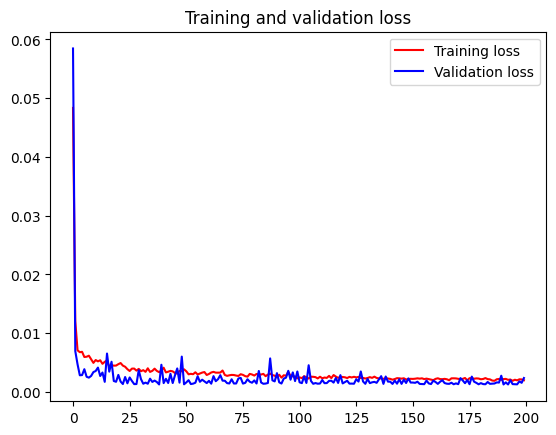

<Figure size 640x480 with 0 Axes>

In [31]:
#Plotting the loss chart
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [32]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)

test_predict=model.predict(X_test)

train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 7ms/step


((586, 1), (135, 1))

In [33]:
#Model Evaluation - Transform back the data (i.e. Inverse Scaling)
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [34]:
#Evaluation metrices RMSE, MSE and MAE
#RMSE, MSE and MAE - measure the error of a model in predicting quantitative data
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))

print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))

print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("-------------------------------------------------------------------------------------")

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))

print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  5.417276998383627
Train data MSE:  29.346890077216315
Train data MAE:  4.233185877759707
-------------------------------------------------------------------------------------
Test data RMSE:  6.362055895888037
Test data MSE:  40.47575522240374
Test data MAE:  5.305180081004048


In [35]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))

print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9734067001016536
Test data explained variance regression score: 0.9471651085740539


In [36]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.967936797740856
Test data R2 score: 0.9002503848868721


In [37]:
#Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))

print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")

print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))

print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0003977325953037347
Test data MGD:  0.0003473521163201066
----------------------------------------------------------------------
Train data MPD:  0.10742864776687135
Test data MPD:  0.11839547480236703


In [38]:
#Comparison of original stock close price and predicted close price
# shift train predictions for plotting the look-ahead time for predicted stock values

# First delete the 'date' column from below df to make it a single column df
# so that train_predict_look_ahead variable can be properly structured
del df_close['date']

look_back=time_step

train_predict_look_ahead = np.empty_like(df_close)

train_predict_look_ahead[:, :] = np.nan

# For looking ahead by look_back, I need to start at look_back
train_predict_look_ahead[look_back:len(train_predict)+look_back, :] = train_predict

print("Train predicted data: ", train_predict_look_ahead.shape)

####################### TEST #############################
# shift test predictions for plotting
test_predict_look_ahead = np.empty_like(df_close)

test_predict_look_ahead[:, :] = np.nan

test_predict_look_ahead[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict

print("Test predicted data: ", test_predict_look_ahead.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': df_close['date'],
                       'original_close': df_close['close'],
                      'train_predicted_close': train_predict_look_ahead.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': test_predict_look_ahead.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

KeyError: 'date'